In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
import json
import re
import pickle

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
base_directory = "/Volumes/ChemLab/04_Processing/Data Backups/Session "

In [3]:
debug = False # make true for debugging prints
export = False

In [4]:
# json field

pid = 'phetioID'
event = 'event'
time = 'time'

In [5]:
session_start = 1
session_end = 32

In [6]:
# load the phetid - event mapping

file = open("phet_map.pkl", "rb")
events = pickle.load(file)

In [7]:
path = ["..", "data", "carmen_post_test.pkl"]
data_path = os.path.join(*path)

with open(data_path , "rb") as f:
    df = pd.read_pickle(data_path)

## Useful mapping for parsing interactions

In [8]:
phet_map = {
    'probe': {
        pid: ['beersLawLab.beersLawScreen.view.detectorNode.probeNode.movableDragHandler'],
        'start': 'dragStarted',
        'end': 'dragEnded',
        'ongoing': 'dragged'
    },
    'container': {
        pid: ['beersLawLab.beersLawScreen.view.cuvetteNode.cuvetteDragHandler'],
        'start': 'dragStarted',
        'end': 'dragEnded',
        'ongoing': 'dragged'
    },
    'laser': {
        pid: ['beersLawLab.beersLawScreen.view.lightNode.button'],
        'start': 'toggled'
    },
    'pdf': {
        pid: ['beersLawLab.wrapper'],
        'start': 'showPDF',
        'end': 'hidePDF'
    },
    'wavelength_variable': {
        pid: [
            'beersLawLab.beersLawScreen.view.wavelengthControls.variableWavelengthRadioButton',
            'beersLawLab.beersLawScreen.view.wavelengthControls.presetWavelengthRadioButton'
        ],
        'start': 'fired'
    },
    'wavelength_slider': {
        pid: [
            'beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.thumbInputListener',
            'beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.trackInputListener'
        ],
        'start': 'dragStarted',
        'end': 'dragEnded',
        'ongoing': 'dragged'
    },
    'wavelength_button': {
        pid: [
            'beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.minusButton',
            'beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.plusButton'
        ],
        'start': 'fired',
    },
    'concentration_slider': {
        pid: [
            'beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.thumb.dragHandler',
            'beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.track.inputListener'
        ],
        'start': 'dragStarted',
        'end': 'dragEnded',
        'ongoing': 'dragged'
    },
    'concentration_button': {
        pid: [
            'beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.minusButton',
            'beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.plusButton'
        ],
        'start': 'fired'
    },
    'solution': {
        pid: ['beersLawLab.beersLawScreen.view.solutionControls.comboBox'],
        'start': 'popupShown',
        'end': 'popupHidden',
        'fired': 'fired'
    },
    'ruler': {
        pid: ['beersLawLab.beersLawScreen.view.rulerNode.movableDragHandler'],
        'start': 'dragStarted',
        'end': 'dragEnded',
        'ongoing': 'dragged'
    },
    'absorbance': {
        pid: ['beersLawLab.beersLawScreen.view.detectorNode.bodyNode.absorbanceRadioButton'],
        'start': 'fired'
    },
    'transmittance': {
        pid: ['beersLawLab.beersLawScreen.view.detectorNode.bodyNode.transmittanceRadioButton'],
        'start': 'fired'
    },
    'reset': {
        pid: ['beersLawLab.beersLawScreen.view.resetAllButton'],
        'start': 'fired'
    }
}

In [9]:
group_interactions = {
    'container': ['container'],
    'solution': ['solution'],
    'wavelength': ['wavelength_slider', 'wavelength_button'],
    'concentration': ['concentration_slider', 'concentration_button'],
    'measuring': ['probe', 'ruler', 'absorbance', 'transmittance', 'wavelength_variable', 'laser']
}

independent_elements = ['pdf', 'reset']

In [10]:
interactions_list = list(phet_map.keys())

# Parse raw data

## Classes

In [11]:
class Participant():
    def __init__(self, participant_id, session, ranking, label):
        self.id = participant_id
        self.session = session
        self.ranking = ranking
        self.label = label
        
        # keep track of the simulation tested:
        # left - concentration (the wrong one)
        # right - beer's law (the expected one)
        # there are participants who tested both or just one
        self.left_simulation = False
        self.right_simulation = False
        
        # save the default state
        # helps not counting consecutive clicks on absorbance / transmittance
        self.transmittance_on = {
            1: True,
            2: True,
            3: True
        }
        
        # laser state - on / off
        self.laser_on = {
            1: False,
            2: False,
            3: False
        }
        
        # array of interactions
        self.interactions = {
            1: [],
            2: [],
            3: []
        }
        
        # counts for all the interactions
        self.interactions_count = {
            1: {i: 0 for i in interactions_list},
            2: {i: 0 for i in interactions_list},
            3: {i: 0 for i in interactions_list}
        }
        
        # Special case: solution interaction
        # refers to the latest Solution Interaction object
        # since it can be left open while the user interacts with other components
        self.solutionPopup = None

        
    def count_interactions(self):
        for task in [1, 2, 3]:
            
            if len(self.interactions[task]) == 0:
                continue
                
            # set default transmittance at the beginning of every task
            start_time = self.interactions[task][0].start_time
            last_transmittance = Transmittance(phet_map['transmittance'][pid][0], 'transmittance', start_time, start_time)
            self.interactions[task].insert(0, last_transmittance)
            
            # counts
            for i in self.interactions[task]:
                self.interactions_count[task][i.name] += 1

                
    def get_interaction_count(self, interaction, task):
        return self.interactions_count[task][interaction]
    
    def prepare_export(self):
        export_data = {
            1: {},
            2: {},
            3: {}
        }
        
        for i in [1, 2, 3]:
            export_data[i] = {
                'sequence': [],
                'begin': [],
                'end': [],
                'permutation': self.ranking,
                'learner_id': self.id
            }
            
            for j in self.interactions[i]:
                
                # form sequence key
                if j.name in independent_elements:
                    export_data[i]['sequence'].append(j.name)
                else:
                    sequence = [k for k in group_interactions.keys() if j.name in group_interactions[k]][0]
                    sequence += '_transmittance' if j.transmittance_on else '_absorbance'
                    sequence += '_laserOn' if j.laser_on else '_laserOff'
                    export_data[i]['sequence'].append(sequence)
                    
                export_data[i]['begin'].append(j.start_time)
                export_data[i]['end'].append(j.end_time)
                
        return export_data
    

    ### debugging functions ###
                
    def print_interactions_count(self):
        for task in [1, 2, 3]:
            print(self.id, task)
            for k, v in self.interactions_count[task].items():
                print(k, v)
            print()
        print("================================")
    
    def print_interaction(self, interaction, task):
        for i in self.interactions[task]:
            if i.name == interaction:
                print(i.name, i.start_time, i.end_time)    
        print("================================")

In [12]:
# parent Interaction class
class Interaction():
    def __init__(self, phetioID=0, name='', start_time=0, end_time=0, transmittance_on=True, laser_on=False):
        self.phetioID = phetioID
        self.name = name
        self.start_time = start_time
        self.end_time = end_time
        self.transmittance_on = transmittance_on
        self.laser_on = laser_on

In [13]:
# for interactions with the container's width

class Container(Interaction):
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        start_time = logs[log_index][time]
        log_index += 1
        
        if log_index >= len(logs):
            return log_index
        
        # skip over multiple dragged event => accounting as just one interaction
        while log_index < len(logs) and logs[log_index][event] != phet_map[name]['end']:
            log_index += 1

        if log_index == len(logs):
            log_index -= 1
        end_time = logs[log_index][time]

        # create the interaction for the participant
        container = Container(phet_map[name], name, start_time, end_time,
                              participant.transmittance_on[task], participant.laser_on[task])
        ids[participant.id].interactions[task].append(container)

        # return the index of next iteraction
        return log_index + 1   

In [14]:
# for toggling absorbance

class Absorbance(Interaction):
    
    def parse(self, name, participant, task, logs, log_index):
        if participant.transmittance_on[task] == True:
            participant.transmittance_on[task] = False
        else:
            return log_index + 1
        
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        # create the interaction for the participant
        start_time = logs[log_index][time]
        absorbance = Absorbance(phet_map[name], name, start_time, start_time + 1)
        ids[participant.id].interactions[task].append(absorbance)

        # return the index of next iteraction
        return log_index + 1   

In [15]:
# for toggling transmittance

class Transmittance(Interaction):
    
    def parse(self, name, participant, task, logs, log_index):
        if participant.transmittance_on[task] == False:
            participant.transmittance_on[task] = True
        else:
            return log_index + 1
        
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}" + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        # create the interaction for the participant
        start_time = logs[log_index][time]
        transmittance = Transmittance(phet_map[name], name, start_time, start_time + 1)
        ids[participant.id].interactions[task].append(transmittance)

        # return the index of next iteraction
        return log_index + 1 

In [16]:
# for selection a solution

class Solution(Interaction):
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}") 
        
        ## Case 1: complete solution interactions
        ## popupShown - fired (a solution is selected)
        ## popupShown - popupHidden (nothing is selected)
        if log_index + 1 < len(logs) and (logs[log_index + 1]['event'] == phet_map[name]['fired'] or logs[log_index + 1]['event'] == phet_map[name]['end']):
            start_time = logs[log_index]['time'] # get start time, for 'popupShown'
            end_time = logs[log_index + 1]['time'] # get end time, for 'fired' or 'popupHidden' (right after 'popupShown')
            solution = Solution(phet_map[name], name, start_time, end_time,
                                participant.transmittance_on[task], participant.laser_on[task])
            ids[participant.id].interactions[task].append(solution)
            
            # return the index of first unchecked iteraction
            return log_index + 2
        
        
        ## Case 2: popupShown - other interactions - popupHidden (hidden automatically from another interaction)
        else:
            if ids[participant_id].solutionPopup != None:
                print('[parse_log]: solution error - start without a previous end', logs[log_index]['messageIndex'])
            
            start_time = logs[log_index]['time'] # get start time, for 'popupShown'
            solution = Solution(phet_map[name], name, start_time, start_time,
                                participant.transmittance_on[task], participant.laser_on[task]) # end time will be set later
            ids[participant.id].interactions[task].append(solution)
            ids[participant.id].solutionPopup = solution
            
        return log_index + 1 

In [17]:
# for toggling the laser

class Laser(Interaction):
    
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        # create the interaction for the participant
        start_time = logs[log_index][time]
        laser = Laser(phet_map[name], name, start_time, start_time + 1)
        ids[participant.id].interactions[task].append(laser)
        
        participant.laser_on[task] = not participant.laser_on[task]

        # return the index of next iteraction
        return log_index + 1   

In [18]:
# for adjusting the concentration level using the slider

class ConcentrationSlider(Interaction):
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        start_time = logs[log_index][time]
        log_index += 1
        
        if log_index >= len(logs):
            return log_index

        # skip over multiple dragged event => accounting as just one interaction
        while log_index < len(logs) and logs[log_index][event] != phet_map[name]['end']:
            log_index += 1

        if log_index == len(logs):
            log_index -= 1
        end_time = logs[log_index][time]

        # create the interaction for the participant
        concentration = ConcentrationSlider(phet_map[name], name, start_time, end_time,
                                            participant.transmittance_on[task], participant.laser_on[task])
        ids[participant.id].interactions[task].append(concentration)

        # return the index of next iteraction
        return log_index + 1   

In [19]:
# for adjusting the concentration level using the buttons

class ConcentrationButton(Interaction):
    def __init__(self, phetioID=0, name='', start_time=0, end_time=0, transmittance_on=False, laser_on=False, direction=None):
        super().__init__(phetioID, name, start_time, end_time, transmittance_on, laser_on)
        self.direction = direction
    
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        # create the interaction for the participant
        start_time = logs[log_index][time]
        phetioID = logs[log_index][pid]
        direction = logs[log_index][pid].split('.')[-1]
        
        while log_index < len(logs) and logs[log_index][pid] == phetioID:
            log_index += 1
            
        end_time = logs[log_index - 1][time]
        concentration_button = ConcentrationButton(phet_map[name], name, start_time, end_time,
                                                   participant.transmittance_on[task], participant.laser_on[task], direction)
        ids[participant.id].interactions[task].append(concentration_button)

        # return the index of next iteraction
        return log_index

In [20]:
# for activate the variable wavelength

class WavelengthVariable(Interaction):
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        # create the interaction for the participant
        start_time = logs[log_index][time]
        wavelength = WavelengthVariable(phet_map[name], name, start_time, start_time + 1)
        ids[participant.id].interactions[task].append(wavelength)

        # return the index of next iteraction
        return log_index + 1   

In [21]:
# for adjusting the wavelength using the slider

class WavelengthSlider(Interaction):
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        start_time = logs[log_index][time]
        log_index += 1
        
        if log_index >= len(logs):
            return log_index

        # skip over multiple events => accounting as just one interaction
        while log_index < len(logs) and logs[log_index][event] != phet_map[name]['end']:
            log_index += 1

        if log_index == len(logs):
            log_index -= 1
        end_time = logs[log_index][time]

        # create the interaction for the participant
        wavelength = WavelengthSlider(phet_map[name], name, start_time, end_time,
                                      participant.transmittance_on[task], participant.laser_on[task])
        ids[participant.id].interactions[task].append(wavelength)

        # return the index of next iteraction
        return log_index + 1   

In [22]:
# for adjusting the wavelength using the buttons

class WavelengthButton(Interaction):
    def __init__(self, phetioID=0, name='', start_time=0, end_time=0, transmittance_on=True, laser_on=False, direction=None):
        super().__init__(phetioID, name, start_time, end_time, transmittance_on, laser_on)
        self.direction = direction
        
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        # create the interaction for the participant
        start_time = logs[log_index][time]
        phetioID = logs[log_index][pid]
        direction = logs[log_index][pid].split('.')[-1]
        
        while log_index < len(logs) and logs[log_index][pid] == phetioID:
            log_index += 1

        end_time = logs[log_index - 1][time]
        wavelength_button = WavelengthButton(phet_map[name], name, start_time, end_time,
                                             participant.transmittance_on[task], participant.laser_on[task], direction)
        ids[participant.id].interactions[task].append(wavelength_button)

        # return the index of next iteraction
        return log_index

In [23]:
# for moving the ruler

class Ruler(Interaction):
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        start_time = logs[log_index][time]
        log_index += 1
        
        if log_index >= len(logs):
            return log_index

        # skip over multiple dragged event => accounting as just one interaction
        while log_index < len(logs) and logs[log_index][event] != phet_map[name]['end']:
            log_index += 1

        if log_index == len(logs):
            log_index -= 1
        end_time = logs[log_index][time]

        # create the interaction for the participant
        ruler = Ruler(phet_map[name], name, start_time, end_time,
                    participant.transmittance_on[task], participant.laser_on[task])
        ids[participant.id].interactions[task].append(ruler)

        # return the index of next iteraction
        return log_index + 1  

In [24]:
# for opening / closing the pdf

class Pdf(Interaction):
    
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        start_time = logs[log_index][time]
        log_index += 1
        
        if log_index >= len(logs):
            # for when the hidePDF event is missing => this happens when the PDF is opened as the last thing in the simulation
            end_time = start_time + 1
        else:
            end_time = logs[log_index][time]

        # create the interaction for the participant
        pdf = Pdf(phet_map[name], name, start_time, end_time,
                  participant.transmittance_on[task], participant.laser_on[task])
        ids[participant.id].interactions[task].append(pdf)

        # return the index of next iteraction
        return log_index + 1   

In [25]:
# for dragging the probe - distraction

class Probe(Interaction):
    
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        start_time = logs[log_index][time]
        log_index += 1
        
        # skip over multiple dragged event => accounting as just one interaction
        while log_index < len(logs) and logs[log_index][event] != phet_map[name]['end']:
            log_index += 1

        if log_index == len(logs):
            log_index -= 1
        end_time = logs[log_index][time]
        
        # create the interaction for the participant
        probe = Probe(phet_map[name], name, start_time, end_time,
                      participant.transmittance_on[task], participant.laser_on[task])
        ids[participant.id].interactions[task].append(probe)

        # return the index of next iteraction
        return log_index + 1       

In [26]:
# for clicking on the rest button

class Reset(Interaction):
    def parse(self, name, participant, task, logs, log_index):
        if debug:
            print(f"[parse_{name}]: session={participant.session}, participant={participant.id}, task={task}, " + 
                  f"index={log_index}, messageIndex={logs[log_index]['messageIndex']}")

        # create the interaction for the participant
        start_time = logs[log_index][time]
        reset = Reset(phet_map[name], name, start_time, start_time + 1,
                      participant.transmittance_on[task], participant.laser_on[task])
        ids[participant.id].interactions[task].append(reset)
        
        # reset transmittance and laser
        participant.transmittance_on[task] = True
        participant.laser_on[task] = False

        # return the index of next iteraction
        return log_index + 1

## Parser

In [27]:
phetioIDs = set() # set of ids, to help distinguish between news and older ones
wrong_phetioIDs = set() # set of ids for the wrong simulation (the one on the left)

# add ids for the interactions when selecting the simulation 
phetioIDs.update([
 'beersLawLab.homeScreen.view.beersLawScreenLargeButton',
 'beersLawLab.homeScreen.view.beersLawScreenSmallButton',
 'beersLawLab.homeScreen.view.concentrationScreenLargeButton',
 'beersLawLab.homeScreen.view.concentrationScreenSmallButton',
 'beersLawLab.homeScreen.view.phetButton',
 'beersLawLab.homeScreen.view.phetButton.phetMenu.aboutButton',
 'beersLawLab.navigationBar.beersLawScreenButton',
 'beersLawLab.navigationBar.concentrationScreenButton',
 'beersLawLab.navigationBar.homeButton',
 'beersLawLab.navigationBar.phetButton',
 'beersLawLab.navigationBar.phetButton.phetMenu.aboutButton',
 'beersLawLab.navigationBar.phetButton.phetMenu.screenshotMenuItem',
 'beersLawLab.sim',
 'beersLawLab.sim.barrierRectangle',
 'beersLawLab.sim.screenIndexProperty',
 'beersLawLab.simIFrameAPI',
 'beersLawLab.wrapper'])


# interactions from the wrong simulation (Concentration)
wrong_phetioIDs.update([
 'beersLawLab.concentrationScreen.model.concentrationMeter.valueProperty',
 'beersLawLab.concentrationScreen.model.solution.soluteAmountProperty',
 'beersLawLab.concentrationScreen.model.solution.volumeProperty',
 'beersLawLab.concentrationScreen.view.concentrationMeterNode.bodyNode.movableDragHandler',
 'beersLawLab.concentrationScreen.view.concentrationMeterNode.probeNode.movableDragHandler',
 'beersLawLab.concentrationScreen.view.drainFaucetNode',
 'beersLawLab.concentrationScreen.view.drainFaucetNode.inputListener',
 'beersLawLab.concentrationScreen.view.dropperNode.button',
 'beersLawLab.concentrationScreen.view.dropperNode.movableDragHandler',
 'beersLawLab.concentrationScreen.view.evaporationControl.slider.thumbInputListener',
 'beersLawLab.concentrationScreen.view.evaporationControl.slider.track.trackInputListener',
 'beersLawLab.concentrationScreen.view.removeSoluteButton',
 'beersLawLab.concentrationScreen.view.resetAllButton',
 'beersLawLab.concentrationScreen.view.shakerNode.inputListener',
 'beersLawLab.concentrationScreen.view.soluteControls.soluteComboBox',
 'beersLawLab.concentrationScreen.view.soluteControls.soluteFormNode.solidRadioButton',
 'beersLawLab.concentrationScreen.view.soluteControls.soluteFormNode.solutionRadioButton',
 'beersLawLab.concentrationScreen.view.solventFaucetNode',
 'beersLawLab.concentrationScreen.view.solventFaucetNode.inputListener'])


# interactions from the correct simulation (Beer's Law)
phetioIDs.add("beersLawLab.beersLawScreen.view.detectorNode.probeNode.movableDragHandler")
phetioIDs.add("beersLawLab.beersLawScreen.view.cuvetteNode.cuvetteDragHandler")
phetioIDs.add("beersLawLab.beersLawScreen.view.lightNode.button")
phetioIDs.add("beersLawLab.wrapper")
phetioIDs.add("beersLawLab.beersLawScreen.view.wavelengthControls.variableWavelengthRadioButton")
phetioIDs.add("beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.thumb.dragHandler")
phetioIDs.add("beersLawLab.beersLawScreen.view.solutionControls.comboBox")
phetioIDs.add("beersLawLab.beersLawScreen.view.rulerNode.movableDragHandler")
phetioIDs.add("beersLawLab.beersLawScreen.view.detectorNode.bodyNode.absorbanceRadioButton")
phetioIDs.add("beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.minusButton")
phetioIDs.add("beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.plusButton")
phetioIDs.add("beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.thumbInputListener")
phetioIDs.add("beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.trackInputListener")
phetioIDs.add("beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.minusButton")
phetioIDs.add("beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.plusButton")
phetioIDs.add("beersLawLab.beersLawScreen.view.detectorNode.bodyNode.transmittanceRadioButton")
phetioIDs.add("beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.track.inputListener")
phetioIDs.add("beersLawLab.beersLawScreen.view.wavelengthControls.presetWavelengthRadioButton")
phetioIDs.add("beersLawLab.beersLawScreen.view.resetAllButton")

In [28]:
def check_interaction(interaction, participant, logs, log_index, task, name=''):
    log = logs[log_index]
    if log[event] == phet_map[name]['start']:
        if 'ongoing' in phet_map[name]:
            if logs[log_index + 1][event] != phet_map[name]['ongoing']:
                new_index = log_index + 1 # skip the current faulty log
                
        new_index = interaction.parse(name, participant, task, logs, log_index)
    else:
        msgIndex = log['messageIndex']
#         print(f'[check_interaction] error for {name}: unknown start event name \"{log[event]}\". ' +
#               f'Details: user {participant.id} (session {participant.session}) (task {task}), at log[{log_index}] with msgId {msgIndex}. Skipped.')
        new_index = log_index + 1 # skip the current faulty log

    return new_index

In [29]:
def parse_log(participant, task, logs, log_index):
    l = logs[log_index]
    session = participant.session
    participant_id = participant.id
    
    # check if the interaction is specific to the other simulation
    if l[pid] in wrong_phetioIDs:
         # do not recors this interaction
            
        participant.left_simulation = True
        return log_index + 1 # skip the current interaction, maybe they used the right simulation later on
    
    else:
        participant.right_simulation = True
    
    # catch new interactions
    if l[pid] not in phetioIDs:
        print(f"In parse_log, for user {participant_id} ({session}), at log[{log_index}] with msgId {l['messageIndex']}")
        print(f"new interaction with id {l[pid]} in session {session}, {participant_id}, {task}, index {l['messageIndex']}. Please update the code.")
        return -1

    # probe interaction
    if l[pid] in phet_map['probe'][pid]:
        return check_interaction(Probe(), participant, logs, log_index, task, 'probe')
            
    # container interaction
    if l[pid] in phet_map['container'][pid]:
        return check_interaction(Container(), participant, logs, log_index, task, 'container')
            
    # laser interaction
    if l[pid] in phet_map['laser'][pid]:
        return check_interaction(Laser(), participant, logs, log_index, task, 'laser')
            
    # pdf interaction
    if l[pid] in phet_map['pdf'][pid]:
        return check_interaction(Pdf(), participant, logs, log_index, task, 'pdf')
    
    # wavelength variable interaction
    if l[pid] in phet_map['wavelength_variable'][pid]:
        return check_interaction(WavelengthVariable(), participant, logs, log_index, task, 'wavelength_variable')
    
    # wavelength slider interaction
    if l[pid] in phet_map['wavelength_slider'][pid]:
        return check_interaction(WavelengthSlider(), participant, logs, log_index, task, 'wavelength_slider')
    
    # wavelength button interaction
    if l[pid] in phet_map['wavelength_button'][pid]:
        return check_interaction(WavelengthButton(), participant, logs, log_index, task, 'wavelength_button')
    
    # concentration slider interaction
    if l[pid] in phet_map['concentration_slider'][pid]:
        return check_interaction(ConcentrationSlider(), participant, logs, log_index, task, 'concentration_slider')
    
    # concentration buttons interaction
    if l[pid] in phet_map['concentration_button'][pid]:
        return check_interaction(ConcentrationButton(), participant, logs, log_index, task, 'concentration_button')
    
    # solution interaction
    if l[pid] in phet_map['solution'][pid]:
        return check_interaction(Solution(), participant, logs, log_index, task, 'solution')
    
    # ruler interaction
    if l[pid] in phet_map['ruler'][pid]:
        return check_interaction(Ruler(), participant, logs, log_index, task, 'ruler')
    
    # absorbance interaction
    if l[pid] in phet_map['absorbance'][pid]:
        return check_interaction(Absorbance(), participant, logs, log_index, task, 'absorbance')
    
    # absorbance interaction
    if l[pid] in phet_map['transmittance'][pid]:
        return check_interaction(Transmittance(), participant, logs, log_index, task, 'transmittance')
    
    # absorbance interaction
    if l[pid] in phet_map['reset'][pid]:
        return check_interaction(Reset(), participant, logs, log_index, task, 'reset')
    
    # skip the current interaction
    return log_index + 1

In [30]:
# get all ids and parse the logs for each participant for each task
ids = {}
stop = False

for session_id in range(session_start, session_end + 1):
    curr_directory = base_directory + str(session_id)
    
    for filename in os.listdir(curr_directory):
        
        if not filename.endswith(".log"):
            continue
        
        # print("Session", session_id, "participant", filename, end='\r')
        participant_id = filename.split('-')[0] # extract the id
        if participant_id not in ids:    
            ranks = df[df[0, 'username'] == participant_id][1, 'ranks'].values
            if len(ranks) > 0 and ranks[0] != 'missing_answer':
                ranks = ''.join([str(x) for x in ranks[0]])
                label = df[df[0, 'username'] == participant_id][1, 'label'].values[0]
            else:
                ranks = '0000' # missing rank
                label = ''
            ids[participant_id] = Participant(participant_id, session_id, ranks, label)

        task = int(filename[-5]) # get task id (1, 2 or 3)
        data_path = os.path.join(curr_directory, filename)
        file = open(data_path, 'r')

        # correct JSON files :)
        f = file.readlines()
        f = ''.join(f)
        f = re.sub("}\n{", "},\n{", f) # add comma between json objects
        f = "[" + f + "]" # make an array of logs array

        logs = json.loads(f) # finally json
        logs.sort(key=lambda x: (x['time'], x['messageIndex'])) # sort the interactions in place

        i = 0
        while i < len(logs):
            i = parse_log(ids[participant_id], task, logs, i)
            
            if i < 0:
                stop = True
                break
                    
        if stop:
            break # stop - new interaction for the correct simulation

    if stop:
        break # stop - new interaction for the correct simulation

[parse_log]: solution error - start without a previous end 1917
[parse_log]: solution error - start without a previous end 2365
[parse_log]: solution error - start without a previous end 2759
[parse_log]: solution error - start without a previous end 1649
[parse_log]: solution error - start without a previous end 8623
[parse_log]: solution error - start without a previous end 6698
[parse_log]: solution error - start without a previous end 1768
[parse_log]: solution error - start without a previous end 51
[parse_log]: solution error - start without a previous end 8506
[parse_log]: solution error - start without a previous end 3086
[parse_log]: solution error - start without a previous end 2907
[parse_log]: solution error - start without a previous end 11
[parse_log]: solution error - start without a previous end 1632
[parse_log]: solution error - start without a previous end 678
[parse_log]: solution error - start without a previous end 6501
[parse_log]: solution error - start without a

In [31]:
for k in ids.keys():
    ids[k].count_interactions()

## Check if everything is correct - code for debugging

In [32]:
# filename = 'qpmzsb6t-1.log'
# session_id = 3
# curr_directory = base_directory + str(session_id)

# participant_id = filename.split('-')[0] # extract the id
# if participant_id not in ids:
#     ids[participant_id] = Participant(participant_id, session_id)

# task = int(filename[-5]) # get task id (1, 2 or 3)

# data_path = os.path.join(curr_directory, filename)
# file = open(data_path, 'r')

# # correct JSON files :)
# f = file.readlines()
# f = ''.join(f)
# f = re.sub("}\n{", "},\n{", f) # add comma between json objects
# f = "[" + f + "]" # make an array of logs array

# logs = json.loads(f) # finally json
# logs.sort(key=lambda x: (x['time'], x['messageIndex'])) # sort the interactions in place

# i = 0
# while i < len(logs):
#     i = parse_log(ids[participant_id], task, logs, i)

## Exporter Pickle compatible with Jade's phet code

In [33]:
if export:
    # create sessions folders if they dont exist
    export_folder = '../data/sequenced simulations/'
    if not os.path.isdir(export_folder):
        os.mkdir(export_folder)
        for i in range(1, 33):
            os.mkdir(export_folder + 'session' + str(i))
            
    id_dictionary = {
        'limit': 10,
        'sequences': {}
    }

    sequence_count = 0
    for k in ids.keys():
        for i in [1, 2, 3]:
            file_name = export_folder + 'session' + str(ids[k].session) + '/'
            file_name += 'p' + ids[k].ranking + '_lid' + ids[k].id + '_task' + str(i) + '_sequence.pkl'

            id_dictionary['sequences'][sequence_count] = {
                'path': file_name,
                'length': len(ids[k].interactions[i]),
                'learner_id': ids[k].id,
                'task': i
            }

            sequence_count += 1

            export_data = ids[k].prepare_export()
            with open(file_name, 'wb') as handle:
                pickle.dump(export_data[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # export id_dictionary
    with open(export_folder + 'id_dictionary.pkl', 'wb') as handle:
                pickle.dump(id_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Exporter - JSON

In [34]:
class Encoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Interaction):
            serialized_obj = {
                "phetioID": obj.phetioID,
                "name": obj.name,
                "start_time": obj.start_time,
                "end_time": obj.end_time,
            }
            
            if isinstance(obj, ConcentrationButton) or isinstance(obj, WavelengthButton):
                serialized_obj['direction'] = obj.direction
                
            return serialized_obj
        
        if isinstance(obj, Participant):
            serialized_obj = {
                "id": obj.id,
                "session": obj.session,
                "left_simulation": obj.left_simulation,
                "right_simulation": obj.right_simulation,
                "interactions": obj.interactions
            }
            
            return serialized_obj
         
        print("help", obj)
        return json.JSONEncoder.default(self, obj)

In [35]:
if export:
    jsonString = json.dumps(ids, cls=Encoder)
    jsonFile = open("../data/parsed_logs.json", "w")
    jsonFile.write(jsonString)
    jsonFile.close()
    
    path = "/Volumes/ChemLab/04_Processing/Processing/Data/PostTest/post_test.pkl" # when reading from chemlab

    with open(data_path , "rb") as f:
        post_test = pd.read_pickle(path)

## Check all interactions - method 2

In [36]:
def get_mapping_key(interaction_id):
    if interaction_id in phet_map['probe'][pid]:
        return 'probe'
    
    elif interaction_id in phet_map['container'][pid]:
        return 'container'
    
    elif interaction_id in phet_map['wavelength_slider'][pid]:
        return 'wavelength_slider'
    
    elif interaction_id in phet_map['concentration_slider'][pid]:
        return 'concentration_slider'
    
    elif interaction_id in phet_map['ruler'][pid]:
        return 'ruler'
        
    if interaction_id in phet_map['absorbance'][pid]:
        return 'absorbance'
        
    elif interaction_id in phet_map['transmittance'][pid]:
        return 'transmittance'
        
    elif interaction_id in phet_map['reset'][pid]:
        return 'reset'
        
    elif interaction_id in phet_map['concentration_button'][pid]:
        return 'concentration_button'
        
    elif interaction_id in phet_map['wavelength_button'][pid]:
        return 'wavelength_button'
        
    elif interaction_id in phet_map['wavelength_variable'][pid]:
        return 'wavelength_variable'
        
    elif interaction_id in phet_map['laser'][pid]:
        return 'laser'
        
    elif interaction_id in phet_map['pdf'][pid]:
        return 'pdf'
        
    elif interaction_id in phet_map['solution'][pid]:
        return 'solution'

In [37]:
df_counts = pd.DataFrame(columns=['session', 'username', 'task_id'] + interactions_list)
df_counts.head()

,session,username,task_id,probe,container,laser,pdf,wavelength_variable,wavelength_slider,wavelength_button,concentration_slider,concentration_button,solution,ruler,absorbance,transmittance,reset


In [38]:
for session_id in range(session_start, session_end + 1):
    curr_directory = base_directory + str(session_id)
    
    for filename in os.listdir(curr_directory):
        
        if not filename.endswith(".log"):
            continue
        
        print("Session", session_id, "participant", filename, end='\r')
        task = int(filename[-5]) # get task id (1, 2 or 3)
        participant_id = filename.split('-')[0] # extract the id
        
        user = {
            'session': session_id,
            'username': participant_id,
            'task_id': task,
            'probe': 0,
            'container': 0,
            'laser': 0,
            'pdf': 0,
            'wavelength_variable': 0,
            'wavelength_slider': 0,
            'wavelength_button': 0,
            'concentration_slider': 0,
            'concentration_button': 0,
            'solution': 0,
            'ruler': 0,
            'absorbance': 0,
            'transmittance': 0,
            'reset': 0
        }

        data_path = os.path.join(curr_directory, filename)
        file = open(data_path, 'r')

        # correct JSON files :)
        f = file.readlines()
        f = ''.join(f)
        f = re.sub("}\n{", "},\n{", f) # add comma between json objects
        f = "[" + f + "]" # make an array of logs array

        logs = json.loads(f) # finally json
        logs.sort(key=lambda x: (x['time'], x['messageIndex'])) # sort the interactions in place

        transmittance_on = True # default state; do not count multiple clicks on transmittance / absorbance
        
        # count interactions for this logs file
        index = 0
        while index < len(logs):
            event_key = get_mapping_key(logs[index][pid])

            if event_key == None or phet_map[event_key]['start'] != logs[index][event]:
                index += 1
                continue

            # count multiple drag events as one
            if event_key in ['probe', 'container', 'wavelength_slider', 'concentration_slider', 'ruler']:
                start_index = index
                while index < len(logs) and logs[index][event] != 'dragEnded':
                    index += 1

                user[event_key] += 1
                
            elif event_key in ['concentration_button', 'wavelength_button']:
                current_pid = logs[index][pid]
                start_index = index
                while index < len(logs) and logs[index][pid] == current_pid:
                    index += 1

                user[event_key] += 1
                index -= 1 # because it increases at the end of the while loop and there is no 'end event' to skip

            elif event_key == 'solution':
                # for solution - increase only on start event
                if logs[index][event] == phet_map['solution']['start']:
                    user[event_key] += 1
                    
            elif event_key == 'transmittance':
                if not transmittance_on:
                    user[event_key] += 1
                    transmittance_on = True
                    
            elif event_key == 'absorbance':
                if transmittance_on:
                    user[event_key] += 1
                    transmittance_on = False

            else:
                # for the other interactions
                user[event_key] += 1

            index += 1
        
        # add a new row to the dataframe
        df_counts = df_counts.append(user, ignore_index=True)

In [39]:
# filename = '2xjmtbvz-2.log'
# session_id = 1
# curr_directory = base_directory + str(session_id)

# participant_id = filename.split('-')[0] # extract the id
# if participant_id not in ids:
#     ids[participant_id] = Participant(participant_id, session_id)

# task = int(filename[-5]) # get task id (1, 2 or 3)

# data_path = os.path.join(curr_directory, filename)
# file = open(data_path, 'r')

# # correct JSON files :)
# f = file.readlines()
# f = ''.join(f)
# f = re.sub("}\n{", "},\n{", f) # add comma between json objects
# f = "[" + f + "]" # make an array of logs array

# logs = json.loads(f) # finally json
# logs.sort(key=lambda x: (x['time'], x['messageIndex'])) # sort the interactions in place

# # count interactions for this logs file
# index = 0
# while index < len(logs):
        
#     event_key = get_mapping_key(logs[index][pid])
    
#     if event_key == None or phet_map[event_key]['start'] != logs[index][event]:
#         index += 1
#         continue

#     # count multiple drag events as one
        
#     if event_key in ['probe', 'container', 'wavelength_slider', 'concentration_slider', 'ruler']:
#         start_index = index
#         while index < len(logs) and logs[index][event] != 'dragEnded':
#             index += 1

#         user[event_key] += 1
        
#     elif event_key in ['wavelength_button']:
#         current_pid = logs[index][pid]
#         print(event_key, 'start:', logs[index]['messageIndex'])
#         while index < len(logs) and logs[index][pid] == current_pid:
#             index += 1

#         print(event_key, 'end:', logs[index - 1]['messageIndex'])
#         user[event_key] += 1
#         index -= 1

#     elif event_key == 'solution':
#         # for solution - increase only on start event
#         if logs[index][event] == phet_map['solution']['start']:
#             user[event_key] += 1

#     else:
#         # for the other interactions
#         user[event_key] += 1

#     index += 1

In [40]:
# compare the two counts
for c in interactions_list:
    df_counts[c + '_2'] = df_counts.apply(lambda row: ids[row['username']].interactions_count[row['task_id']][c], axis=1)
    df_counts[c + '_match'] = df_counts.apply(lambda row: row[c] == row[c + '_2'], axis=1)

## Check count differences overall

In [41]:
df_counts.head()

,session,username,task_id,probe,container,laser,pdf,wavelength_variable,wavelength_slider,wavelength_button,concentration_slider,concentration_button,solution,ruler,absorbance,transmittance,reset,probe_2,probe_match,container_2,container_match,laser_2,laser_match,pdf_2,pdf_match,wavelength_variable_2,wavelength_variable_match,wavelength_slider_2,wavelength_slider_match,wavelength_button_2,wavelength_button_match,concentration_slider_2,concentration_slider_match,concentration_button_2,concentration_button_match,solution_2,solution_match,ruler_2,ruler_match,absorbance_2,absorbance_match,transmittance_2,transmittance_match,reset_2,reset_match
0,1,2pqdkrkw,1,3,1,1,1,1,0,0,1,0,0,0,0,0,0,3,True,1,True,1,True,1,True,1,True,0,True,0,True,1,True,0,True,0,True,0,True,0,True,1,False,0,True
1,1,2pqdkrkw,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True
2,1,2pqdkrkw,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True,0,True
3,1,2xjmtbvz,1,2,2,1,0,0,0,0,0,3,2,3,1,0,0,2,True,2,True,1,True,0,True,0,True,0,True,0,True,0,True,3,True,2,True,3,True,1,True,1,False,0,True
4,1,2xjmtbvz,2,3,4,1,2,1,5,5,8,0,11,12,2,1,0,3,True,4,True,1,True,2,True,1,True,5,True,5,True,8,True,0,True,11,True,12,True,2,True,2,False,0,True


In [42]:
df_diff = pd.DataFrame(columns=['session', 'username', 'task', 'interaction', 'count_david', 'count_carmen',
                                'count_bruteforce', 'equal_carmen_david', 'equal_carmen_bruteforce', 'equal_david_bruteforce'])

for k in ids.keys():
    for i in [1, 2, 3]:
        counts_carmen = {
            'probe': ids[k].get_interaction_count('probe', i),
            'container': ids[k].get_interaction_count('container', i),
            'laser': ids[k].get_interaction_count('laser', i), 
            'pdf': ids[k].get_interaction_count('pdf', i),
            'wavelength': ids[k].get_interaction_count('wavelength_button', i)
                + ids[k].get_interaction_count('wavelength_slider', i),
            'concentration': ids[k].get_interaction_count('concentration_button', i)
                + ids[k].get_interaction_count('concentration_slider', i),
            'solution': ids[k].get_interaction_count('solution', i),
            'ruler': ids[k].get_interaction_count('ruler', i),
            'absorbance': ids[k].get_interaction_count('absorbance', i),
            'transmittance': ids[k].get_interaction_count('transmittance', i), # for the default state
            'reset': ids[k].get_interaction_count('reset', i),
        }
        
        counts_bruteforce = {
            'probe': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['probe'].values[0],
            'container': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['container'].values[0],
            'laser': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['laser'].values[0], 
            'pdf': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['pdf'].values[0],
            'wavelength': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['wavelength_button'].values[0]
                + df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['wavelength_slider'].values[0],
            'concentration': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['concentration_button'].values[0]
                + df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['concentration_slider'].values[0],
            'solution': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['solution'].values[0],
            'ruler': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['ruler'].values[0],
            'absorbance': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['absorbance'].values[0],
            'transmittance': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['transmittance'].values[0],
            'reset': df_counts[(df_counts['username'] == ids[k].id) & (df_counts['task_id'] == i)]['reset'].values[0]
        }
        
            
        for p in interactions_list:
            if p == 'wavelength_variable':
                continue

            if p in ['wavelength_button', 'wavelength_slider', 'concentration_button', 'concentration_slider']:
                p = p.split("_")[0]
                
            if p == 'reset':
                count_david = 0
            else:
                count_david = df[df[0, 'username'] == k][f'counts_{i - 1}', p].values
                if len(count_david) > 0:
                    count_david = count_david[0]
                else:
                    count_david = 0

            r = {
                'session': ids[k].session,
                'username': ids[k].id,
                'task': i,
                'interaction': p,
                'count_david': count_david,
                'count_carmen': counts_carmen[p],
                'count_bruteforce': counts_bruteforce[p],
                'equal_carmen_david': False,
                'equal_carmen_bruteforce': False,
                'equal_david_bruteforce': False
            }
            
            r['equal_carmen_david'] = (r['count_carmen'] == r['count_david'])
            r['equal_carmen_bruteforce'] = (r['count_carmen'] == r['count_bruteforce'])
            r['equal_david_bruteforce'] = (r['count_david'] == r['count_bruteforce'])
            
            df_diff = df_diff.append(r, ignore_index=True)

In [43]:
df_diff[(df_diff['interaction'] == 'solution') & (df_diff['count_david'] > df_diff['count_carmen'])].head()

,session,username,task,interaction,count_david,count_carmen,count_bruteforce,equal_carmen_david,equal_carmen_bruteforce,equal_david_bruteforce
47,1,2xjmtbvz,1,solution,4.000,2,2,False,True,False
60,1,2xjmtbvz,2,solution,22.000,11,11,False,True,False
73,1,2xjmtbvz,3,solution,8.000,4,4,False,True,False
86,1,3e3k2662,1,solution,14.000,7,7,False,True,False
112,1,3e3k2662,3,solution,30.000,15,15,False,True,False


In [44]:
df_hist = df_diff.groupby(['session', 'interaction']).agg({'count_david':'sum', 'count_carmen':'sum'}).reset_index()

In [45]:
df_hist1 = df_hist.melt(id_vars=['session', 'interaction'], 
              value_vars=['count_david'],
              var_name='from', value_name='count')
df_hist2 = df_hist.melt(id_vars=['session', 'interaction'], 
              value_vars=['count_carmen'],
              var_name='from', value_name='count')

In [46]:
df_hist = pd.concat([df_hist1, df_hist2]).sort_values(by=['session', 'interaction', 'from'])

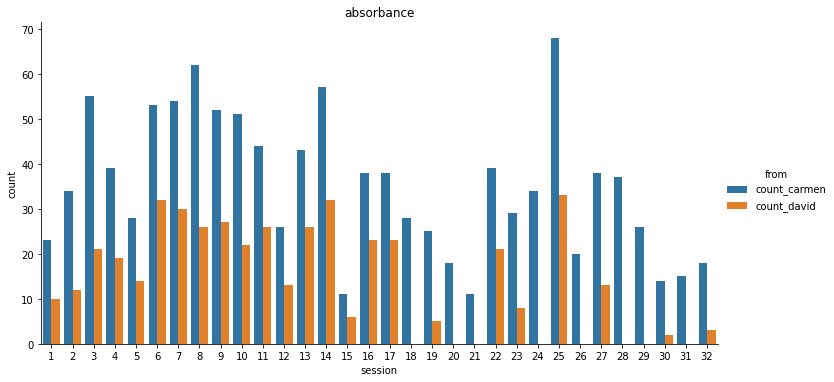

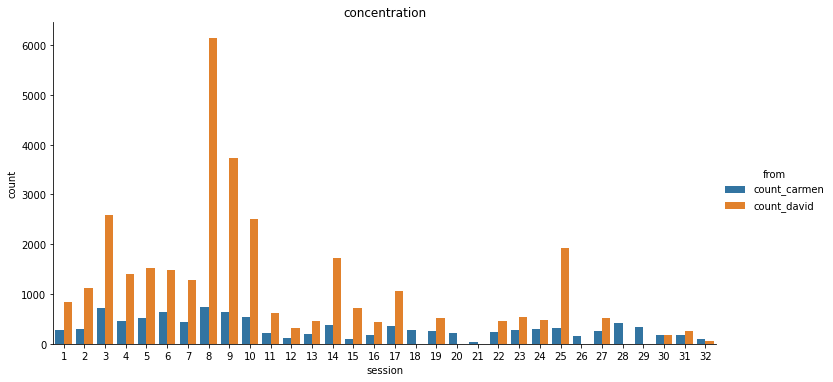

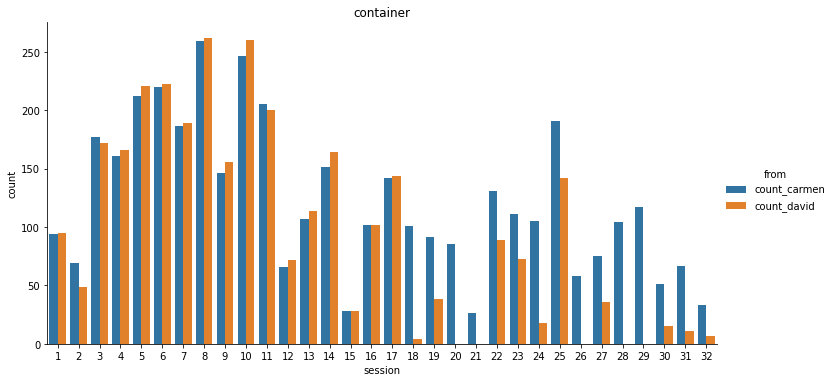

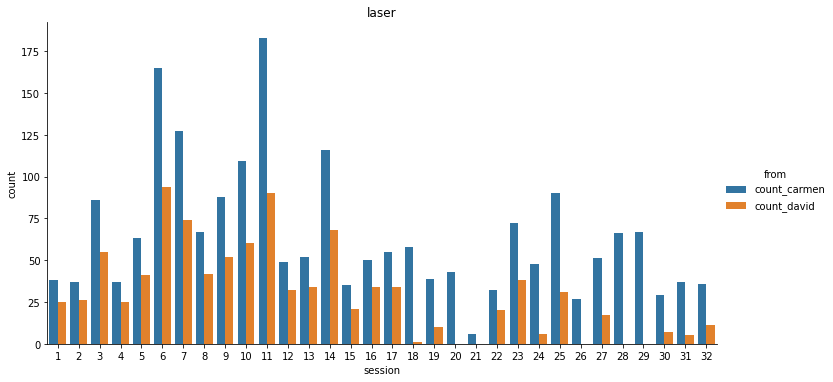

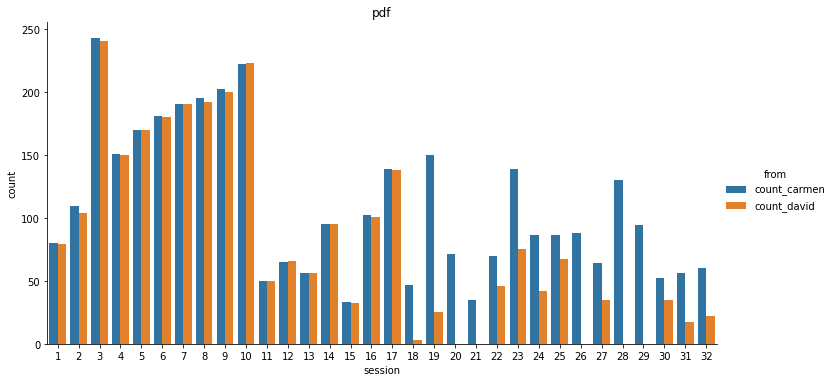

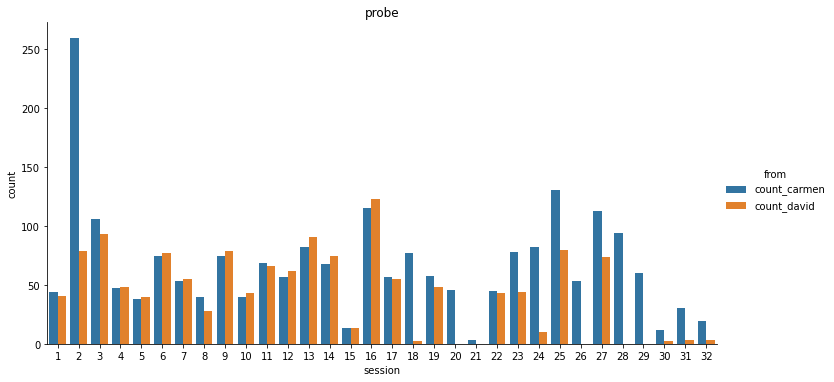

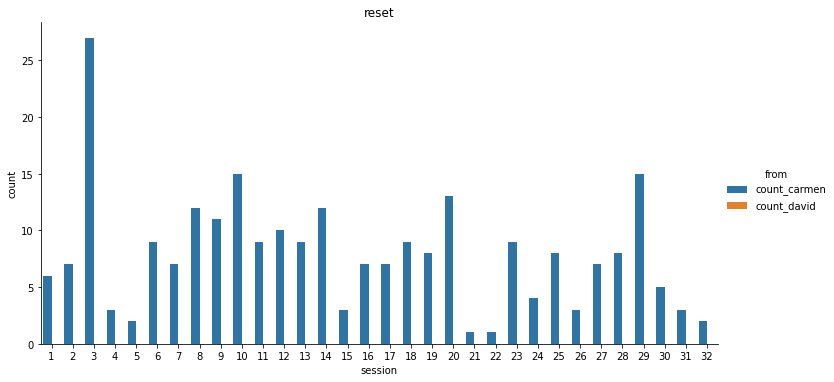

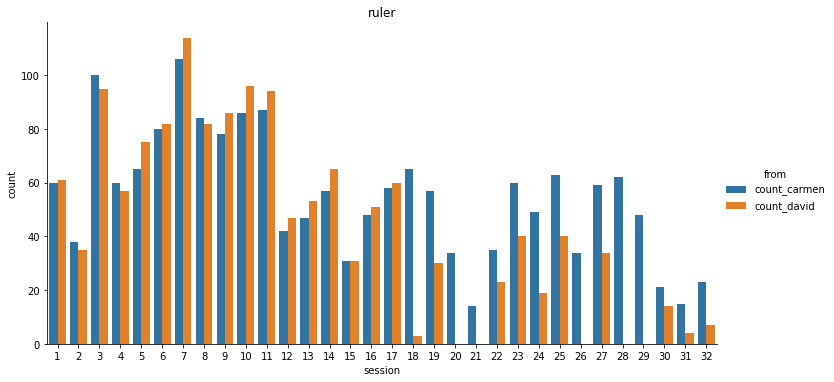

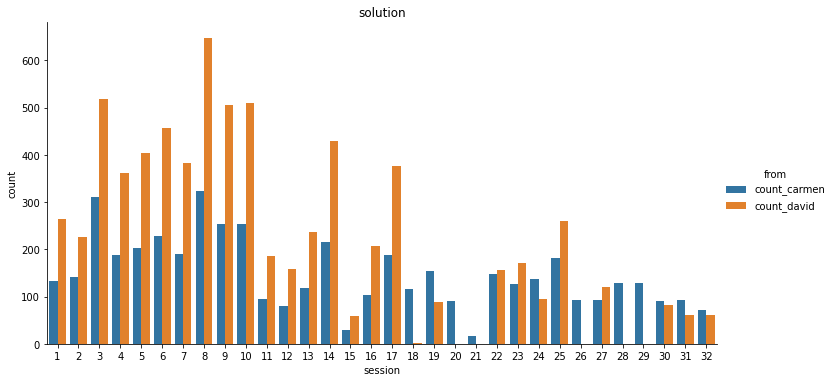

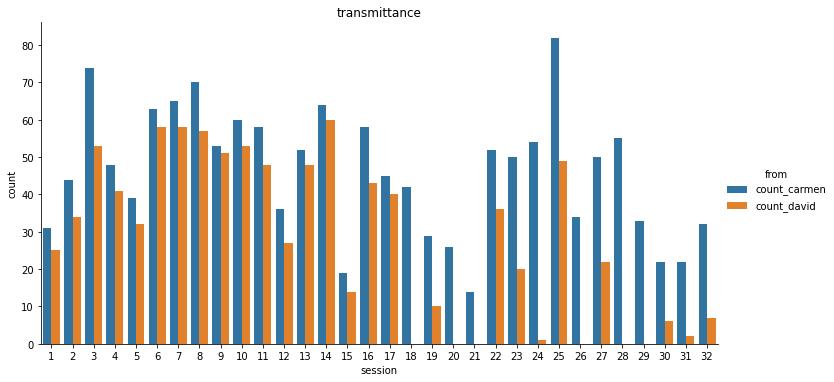

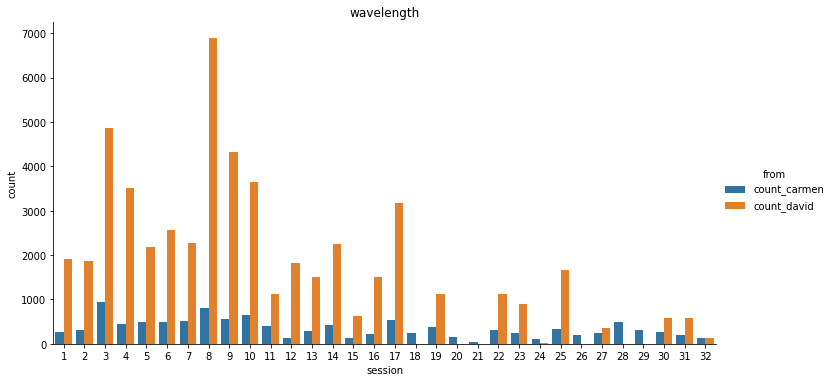

In [47]:
for p in df_hist['interaction'].unique():
    sns.catplot(x="session", y="count", hue="from",
                data=df_hist[df_hist['interaction'] == p],
                kind="bar", height=5, aspect=2).set(title=p)

## Create the phetioid - events mapping

In [48]:
# events = {}

# for session_id in range(1, session_no + 1):
#     curr_directory = base_directory + str(session_id)
    
#     for filename in os.listdir(curr_directory):
        
#          if filename.endswith(".log"):
#             print("Session", session_id, filename, end='\r')
#             data_path = os.path.join(curr_directory, filename)
#             file = open(data_path, 'r')
        
#             # correct JSON files :)
#             f = file.readlines()
#             f = ''.join(f)
#             f = re.sub("}\n{", "},\n{", f) # add comma between json objects
#             f = "[" + f + "]" # make an array of logs array
#             logs = json.loads(f) # finally json

#             for log_index, log in enumerate(logs):
#                 p = log[pid]
                
#                 if p not in events:
#                     events[p] = set()
                    
#                 events[p].add(log['event'])


# file = open("phet_map.pkl", "wb")
# pickle.dump(events, file)
# file.close()